# Homework 4 - Titanic

### Kaggle Classification Competition

Here, we use the Kaggle dataset for Titanic survivors. We'll attempt to predict the survival of passengers of the Titanic based on a set of characteristics we know about them. 

### Background

The Titanic was a large, luxury steamship that had its maiden voyage in April of 1912. At one point in its construction, in 1911, its hull was the largest movable man-made object in the world. It is famous for having what was once considered a "practically unsinkable" design, due to a double bottom and watertight bulkhead compartments.  Unfortunately, on April 15th, 1912, the Titanic crashed into an iceberg and sank, resulting in the deaths of 1502 out of the 2224 who were on board at the time. The belief that the ship was "unsinkable" partly led to the large number of deaths - there were not enough lifeboats for everyone to escape on, and many of those on board had no hope of survival (Info from [Kaggle](https://www.kaggle.com/c/titanic), [History](https://www.history.com/topics/titanic)).

Since over half of the passengers and crew did not survive this accident, we have a large dataset of binary variables - 1 for a survivor, and 0 for someone who went down with the ship. Certain groups tended to survive more than others, such as women and children, as well as higher-class people. In addition to this "survival" variable, we have a set of other information about the passengers, such as their names, ticket number, and fare paid. We'll see how well we can (retroactively) predict the survival of a subset of the passengers on the ship.

First, we'll load in the data we need for this project, along with libraries and packages that will come in handy:

##### Packages, Libraries, and Options:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import sklearn
import missingno as msno
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sns.set(style='ticks', palette='Set2')
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 50)

##### Data:

First we read in the training dataset:

In [31]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We need to separate our "Y variable", survival, from the rest for use in prediction. We'll do that here:

In [32]:
y_train = train_df['Survived']
train_data = train_df.drop('Survived', axis = 1)

Now we read in the testting dataset, as well:

In [33]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Perfect! We see that the datasets are very similar, with the only instantly noticeable difference being that the testing dataset has no data for survival (this makes perfect sense, since we are trying to predict survival). We can only see the first few rows of our data, but there already seem to be at least some issues with missing values and different types of entries. We'll proceed to the data-cleaning step now.

## Cleaning

We need to make sure our training and testing datasets are similarly structured, so as we go through each step, we'll perform each data-cleaning step on both datasets. We do this separately (rather than combining the two datasets) to ensure that our training data doesn't change our testing data unneccessarily.

##### Missing Data:

We'll start by seeing what variables might have missing values:

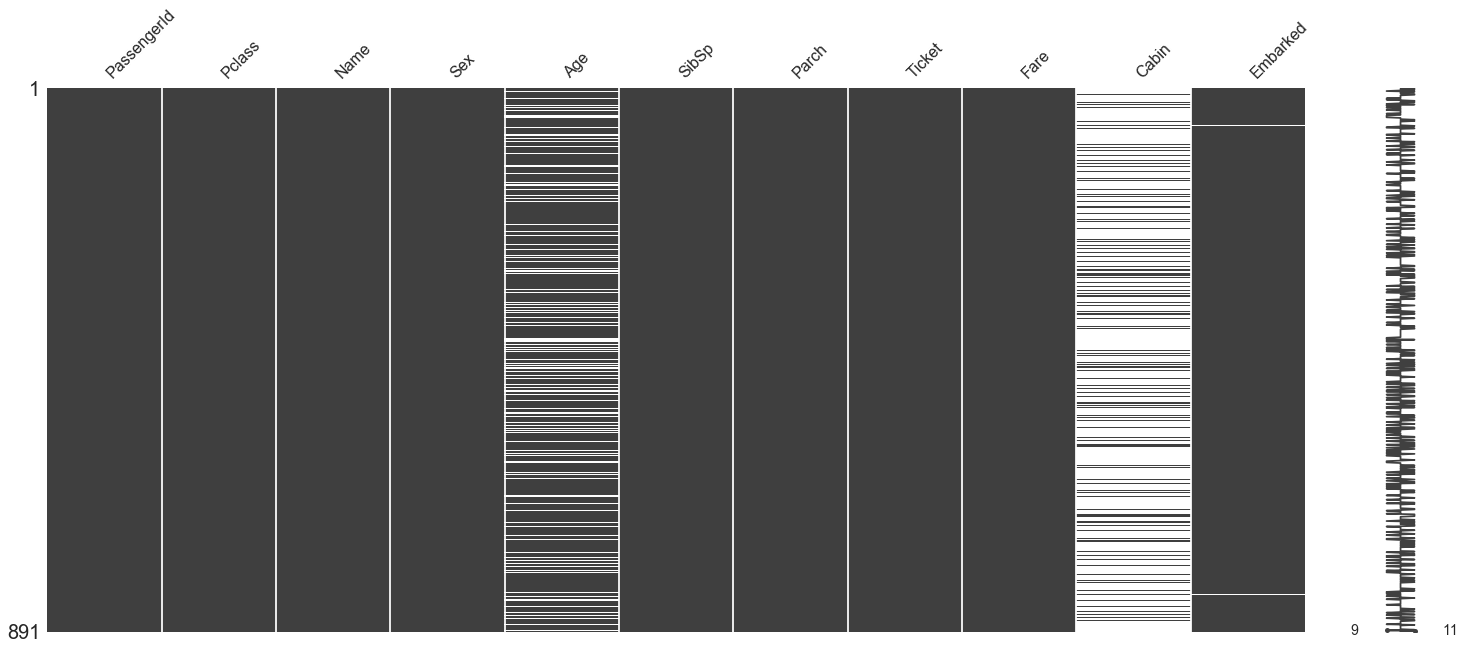

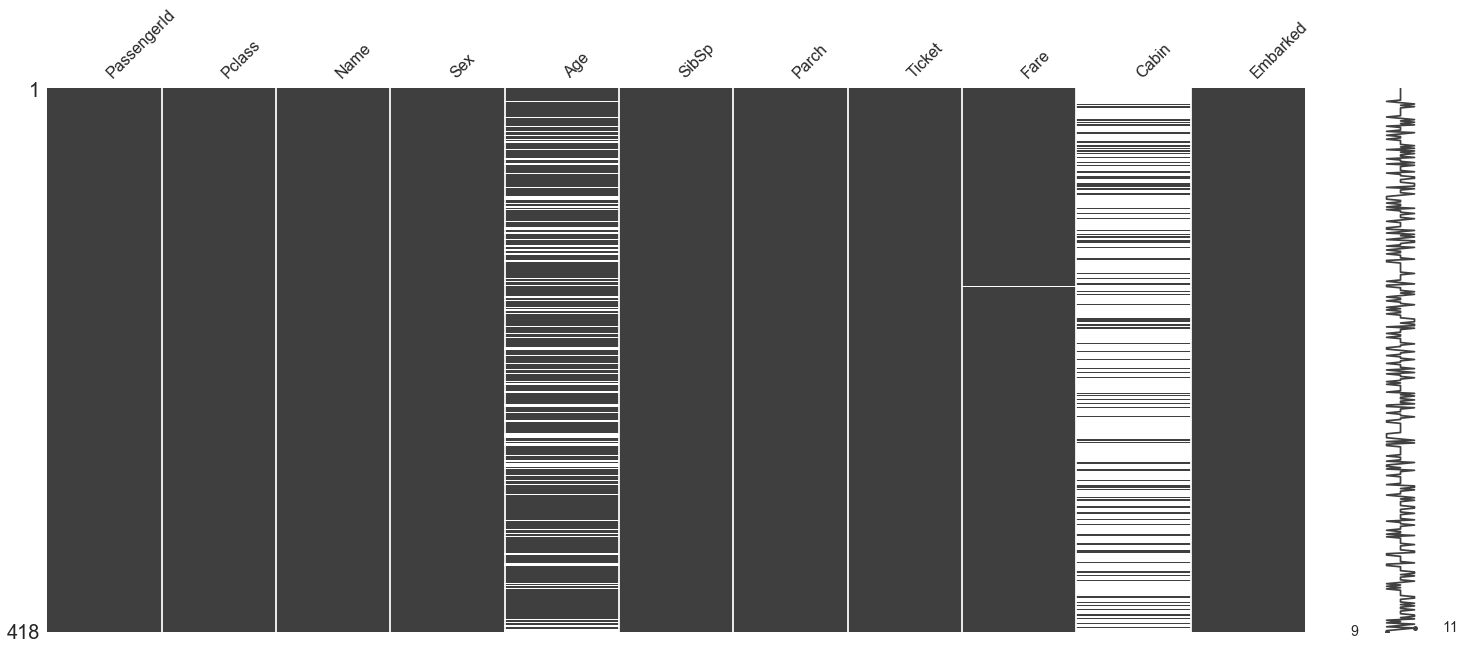

In [34]:
msno.matrix(train_data)
msno.matrix(test_data)

Most of our columns appear to have no missing values, but there are a few in each dataset (most notably, "Age" and "Cabin") that have several. We'll look into this a little more:

In [35]:
train_data.columns[train_data.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [36]:
test_data.columns[test_data.isnull().any()]

Index(['Age', 'Fare', 'Cabin'], dtype='object')

"Age" and "Cabin" are both missing quite a bit of data for both datasets, so we'll have to do something about that. We can also see that there are some other missing values - "Embarked" for the training dataset, and "Fare" for the test dataset. We'll look into any patterns in which data is missing.

First, as we can see below, the "Embarked" and "Fare" columns are only missing a few rows for each dataset. They have the same ticket number and paid the same fare, which is odd, but that may be because they were in the same cabin, and that's how tickets were done back then. Regardless, there are only two passengers, which won't impact our data much. Later on, we'll be making dummy variables for each departure point, and these two will just have 0 for all three possible departure point (which is what the "Embarked" variable is for).

In [37]:
train_data[train_data['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


This passenger has no fare data, which might be more of a problem. However, we note he is in the lower class of passengers.

In [38]:
test_data[test_data['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Before deciding what to do, we'll check the distribution of fares in the training dataset (just to get an idea):

Text(0.5,0,'Fares')

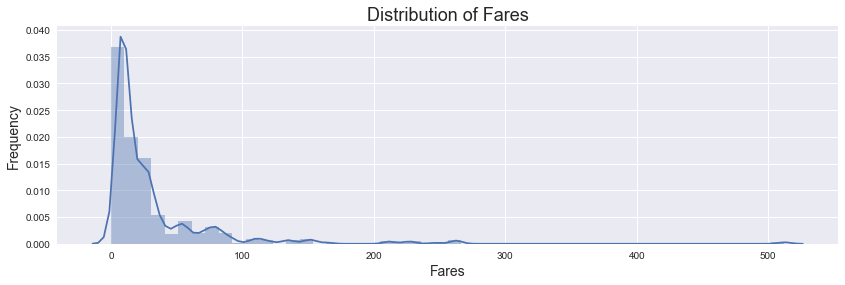

In [39]:
f, ax = plt.subplots(figsize = (14,4))
ax.set_title("Distribution of Fares", fontsize = 18)
sns.distplot(train_data['Fare'], ax = ax)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Fares", fontsize = 14)

We can probably expect the fare distribution for the test dataset to be similar - we'll go ahead and replace this missing fare value with the median value for the training set's fares, and we'll check the distribution after we do that:

Text(0.5,0,'Fares')

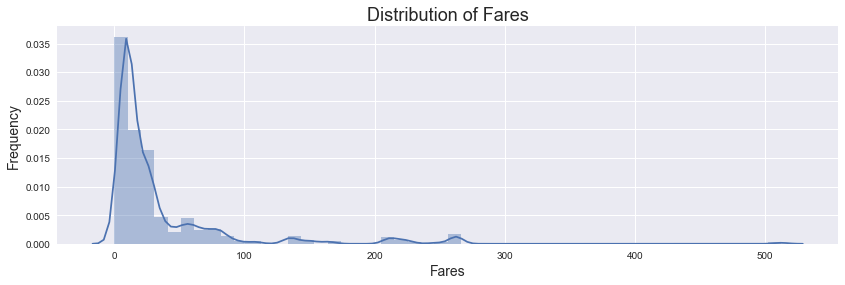

In [40]:
values = {'Fare': test_data['Fare'].median()}
test_data = test_data.fillna(value = values)

f, ax = plt.subplots(figsize = (14,4))
ax.set_title("Distribution of Fares", fontsize = 18)
sns.distplot(test_data['Fare'], ax = ax)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Fares", fontsize = 14)

Perfect! The distribution is similar, so it looks like choosing the median was the right thing to do (it will be closer to the bottom, since this is approximately log-normally distributed).

Now that we've taken care of the smaller issues, we'll take a look at the "Cabin" and "Age" variables. We might suspect that the ship's logs aren't as great for those in the lower classes. We'll check to see if that's true (remember - a 3 stands for the lowest class passenger).

First we look at the Age variable:

In [41]:
pd.DataFrame(train_data[train_data['Age'].isnull()]['Pclass']).describe()

,Pclass
count,177.000000
mean,2.598870
std,0.763216
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,3.000000


As suspected, we see more missing values among the lower-class passengers (at least 50% of all of the missing values for these variables are for lower-class passengers). We'll check how age distributions vary between upper and lower-class passengers:

In [42]:
pd.DataFrame(train_data[train_data['Pclass'] == 3]['Age']).describe()

,Age
count,355.000000
mean,25.140620
std,12.495398
min,0.420000
25%,18.000000
50%,24.000000
75%,32.000000
max,74.000000


In [43]:
pd.DataFrame(train_data[train_data['Pclass'] == 1]['Age']).describe()

,Age
count,186.000000
mean,38.233441
std,14.802856
min,0.920000
25%,27.000000
50%,37.000000
75%,49.000000
max,80.000000


Average age actually varies a bit across classes - as we see below, the lower-class passengers are an average of 13 years younger than the higher-class passengers. Since most of the missing ages are for lower-class passengers, we'll replace their age with the lower-class average age. We'll do that after looking at the Cabin variable:

In [44]:
pd.DataFrame(train_data[train_data['Cabin'].isnull()]['Pclass']).describe()

,Pclass
count,687.000000
mean,2.639010
std,0.589602
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,3.000000


It looks like even more of those missing a cabin value were in the lower-class passenger group. To avoid over-fitting the data (and since cabin group is easier to group by than number), we'll drop the cabin number and just keep the letter.

In [45]:
train_data['CabinLetter'] = train_data.Cabin.str[:1]
train_data = train_data.drop('Cabin', 1)

test_data['CabinLetter'] = test_data.Cabin.str[:1]
test_data = test_data.drop('Cabin', 1)

We'll replace the Cabin Letter value with "N" for "No Cabin" (it's not already a value), and replace missing Age now, too:

In [46]:
print(pd.DataFrame(test_data[test_data['Pclass'] == 3]['Age']).mean())
print("")
print(pd.DataFrame(train_data[train_data['Pclass'] == 3]['Age']).mean())

Age    24.027945
dtype: float64

Age    25.14062
dtype: float64


In [47]:
test_data['CabinLetter'] = test_data.CabinLetter.str[:1]
values = {'CabinLetter': "N", 'Age': 24.028}
test_data = test_data.fillna(value = values)

train_data['CabinLetter'] = train_data.CabinLetter.str[:1]
values = {'CabinLetter': "N", 'Age': 25.141}
train_data = train_data.fillna(value = values)

Now we'll check once more for missing values:

In [48]:
test_data.columns[test_data.isnull().any()]

Index([], dtype='object')

In [49]:
train_data.columns[train_data.isnull().any()]

Index(['Embarked'], dtype='object')

Perfect! Now our only missing values are for "Embarked" in the training dataset (which, as we've already mentioned, is ok - there are only two entries missing values, and we'll just use dummy variables to control for this effect).

##### Cleaning:

We want to make a few new variables. This will require splitting a few string variables into pieces to get what's important. For example, the "Cabin" variable might help us understand more info about the person's status or proximity to a lifeboat, so we'll just take the first letter of this variable (when it exists) to indicate which group of cabins that person was staying in. Even for those who have no cabin information, we can just replace this value with "N" (for "no cabin information"). We can go back later and make

We'll also split up the name to retrieve the title, such as "Mr.", "Reverend", "Doctor", or "Ms.", since certain classes of people may have had priority over others. We'll then drop our unneccessary variables and see how the data looks:

In [50]:
train_data['first'], train_data['titlefirsts'] = train_data['Name'].str.split(', ', 1).str
train_data['Title'], train_data['firsts'] = train_data['titlefirsts'].str.split(' ', 1).str
to_drop = ['Name', 'titlefirsts', 'first', 'firsts']
train_data = train_data.drop(to_drop, 1)
train_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinLetter,Title
0,1,3,male,22.0,1,0,A/5 21171,7.2500,S,N,Mr.
1,2,1,female,38.0,1,0,PC 17599,71.2833,C,C,Mrs.
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,N,Miss.
3,4,1,female,35.0,1,0,113803,53.1000,S,C,Mrs.
4,5,3,male,35.0,0,0,373450,8.0500,S,N,Mr.


We'll do the same for the testing data:

In [51]:
test_data['first'], test_data['titlefirsts'] = test_data['Name'].str.split(', ', 1).str
test_data['Title'], test_data['firsts'] = test_data['titlefirsts'].str.split(' ', 1).str
to_drop = ['Name', 'titlefirsts', 'first', 'firsts']
test_data = test_data.drop(to_drop, 1)
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinLetter,Title
0,892,3,male,34.5,0,0,330911,7.8292,Q,N,Mr.
1,893,3,female,47.0,1,0,363272,7.0000,S,N,Mrs.
2,894,2,male,62.0,0,0,240276,9.6875,Q,N,Mr.
3,895,3,male,27.0,0,0,315154,8.6625,S,N,Mr.
4,896,3,female,22.0,1,1,3101298,12.2875,S,N,Mrs.


We'll now pull the ticket number from the ticket column - it's a bit complicated, since there are sometimes letters and symbols used here:

In [52]:
test_data['TickL1'], test_data['TickL2'], test_data['TicketNum'] = test_data['Ticket'].str.split(' ', 2).str
values = {'TicketNum': test_data['TickL2']}
test_data = test_data.fillna(value = values)
values = {'TicketNum': test_data['TickL1']}
test_data = test_data.fillna(value = values)
test_data = test_data.drop(['TickL1', 'TickL2', 'Ticket'], 1)
test_data['TicketNum'] = test_data['TicketNum'].apply(pd.to_numeric)

We'll do the same thing for the training data, although we need to make one edit (the second to last line) for a troublesome bit of data. We'll replace the value with 300000, since many other 3rd-class passengers have ticket numbers around this (this is a case-specific fix).

In [53]:
train_data['TickL1'], train_data['TickL2'], train_data['TicketNum'] = train_data['Ticket'].str.split(' ', 2).str
values = {'TicketNum': train_data['TickL2']}
train_data = train_data.fillna(value = values)
values = {'TicketNum': train_data['TickL1']}
train_data = train_data.fillna(value = values)
train_data = train_data.drop(['TickL1', 'TickL2', 'Ticket'], 1)
train_data['TicketNum'] = np.where(train_data['TicketNum'] == "LINE", 300000, train_data['TicketNum'])
train_data['TicketNum'] = train_data['TicketNum'].apply(pd.to_numeric)

##### Dummy Variables:

We can see that we have a few string variables that we'd like to turn into numerical dummy variables - we'll do that now:

In [54]:
to_dummies = ['Sex', 'Embarked', 'CabinLetter', 'Title']

for var in to_dummies:
    tempdat = pd.get_dummies(train_data[var], prefix = var)
    train_data = pd.concat([train_data, tempdat], axis = 1)
    
    tempdat = pd.get_dummies(test_data[var], prefix = var)
    test_data = pd.concat([test_data, tempdat], axis = 1)
    

train_data = train_data.drop(to_dummies, 1)
test_data = test_data.drop(to_dummies, 1)

Perfect! We've got everything just how we want it for our analysis. Now we'll visualize a bit of the data so we can understand it.

## Visualization

We've already looked a little bit at Age and Fare distribution. Let's take a look at the training dataset again to use some of the categories there (it'll be easier for our graphs to use it instead of the new, cleaned dataset). We'll make a few edits and then start to look at some charts.

First, we'll make age buckets with 6-year intervals, where the value for "AgeBin" is the largest multiple of 6 less than or equal to the person's age. Then repeat our creation of the cabin group dummy variables. Finally, we'll create a title variable.

In [63]:
train_df['AgeBin'] = train_df['Age'] / .6
train_df['AgeBin'] = np.round(train_df['AgeBin'], -1)
train_df['AgeBin'] = train_df['AgeBin'] * .6

train_df['CabinL'] = train_df.Cabin.str[:1]
values = {'CabinL': "N"}
train_df = train_df.fillna(value = values)

train_df['first'], train_df['titlefirsts'] = train_df['Name'].str.split(', ', 1).str
train_df['Title'], train_df['firsts'] = train_df['titlefirsts'].str.split(' ', 1).str
to_drop = ['Name', 'titlefirsts', 'first', 'firsts']
train_df = train_df.drop(to_drop, 1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBin,CabinL,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,24.0,N,Mr.
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,36.0,C,Mrs.
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,24.0,N,Miss.
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,36.0,C,Mrs.
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,36.0,N,Mr.


Now that we have our new variables, we can look at how survival varies by group. In our first graph, we'll examine average survival rates for men and women, across their age buckets.

Text(0.5,0,'Sex')

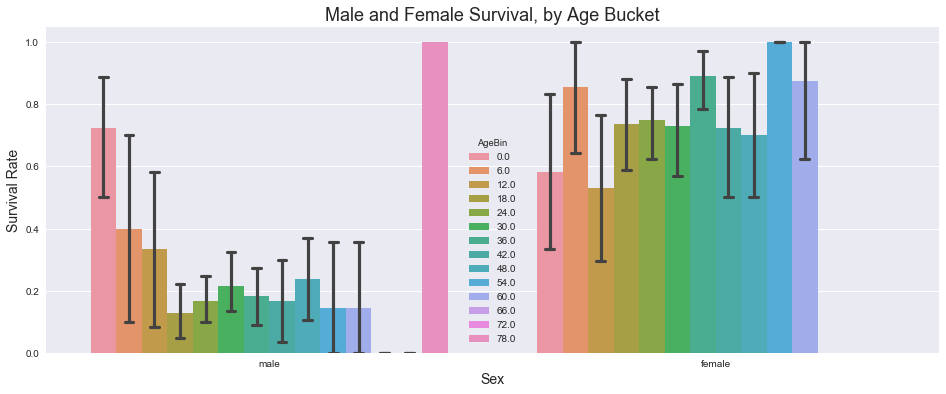

In [78]:
f, ax = plt.subplots(figsize = (16,6))
ax.set_title("Male and Female Survival, by Age Bucket", fontsize = 18)
sns.barplot(x="Sex", y="Survived", hue = "AgeBin", data=train_df, ax = ax, capsize=.02)
plt.ylabel("Survival Rate", fontsize = 14)
plt.xlabel("Sex", fontsize = 14)

We can tell that although men and women have different survival rates across the board, these survival rates depend significantly on the age of the passengers. Over half of the young boys in the training dataset survived, which is a stark difference from those just a decade or two older.

Next, we will examine how survival rates varied by cabin group. Remember that we assigned the group "N" to those who were missing cabin data, and that the other letters came from the cabin variable provided.

Text(0.5,0,'Cabin Group')

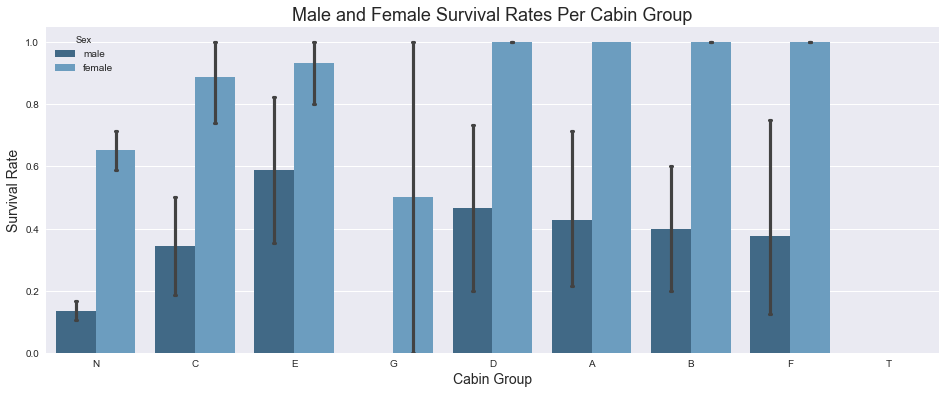

In [74]:
f, ax = plt.subplots(figsize = (16,6))
ax.set_title("Male and Female Survival Rates Per Cabin Group", fontsize = 18)
sns.barplot(x="CabinL", y="Survived", hue="Sex", data=train_df, ax = ax, capsize=.02, palette="Blues_d")
plt.ylabel("Survival Rate", fontsize = 14)
plt.xlabel("Cabin Group", fontsize = 14)

Again, women survived much more frequently. It is interesting to note that although there was less variance in female survival rates by cabin, male survival seems to depend much more on the cabin group.

Finally, we'll examine the graph of survival rate by titles. This is perhaps the most valuable information we can gather from the name variable.

Text(0.5,0,'Title')

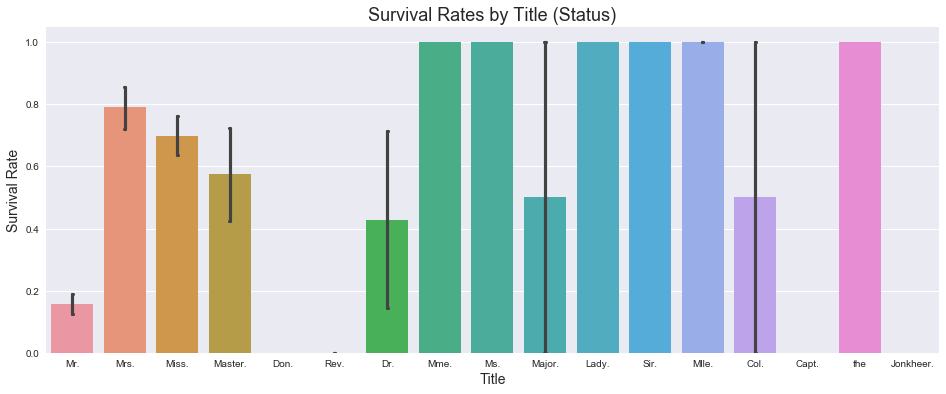

In [79]:
f, ax = plt.subplots(figsize = (16,6))
ax.set_title("Survival Rates by Title (Status)", fontsize = 18)
sns.barplot(x="Title", y="Survived", data=train_df, ax = ax, capsize = .02)
plt.ylabel("Survival Rate", fontsize = 14)
plt.xlabel("Title", fontsize = 14)

Some titles had perfect survival rate - this is most likely due to a very small number of survivors having that title. The interesting part comes from the more common titles, such as "Mr.", "Mrs.", and "Dr.", all of which had different survival rates.

This is interesting, but it is difficult to look at graphs and accurately predict survival. That leads us to the next step - modeling survival rates.

## Modeling

We'll now start the modeling process. First, we import the packages we'll need for this section:

In [80]:
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.linear_model import LogisticRegression as logit
from sklearn.metrics import accuracy_score as AS
from sklearn.metrics import confusion_matrix as CM

### Logistic Regression

We'll start with a simple logistic regression. This has the advantage of being easy to understand - whatever coefficients we receive from our model, we can exponentiate to get an approximate effect of having a certain characteristic (for example, a 30% increase in expected survival if someone is under 12 years old).